## Simple Spam Classifier
Updated:  7/2/2018

This notebook demonstrates an implementation of a spam classifier using Python 3. This classifier with work using probability theory, namely Bayes Theorem to classify text of sample emails as spam or not spam. This practice example comes from <a href'https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73'>Towards Data Science</a>

Bayes Theorum is mathematically expressed as: <img src='https://cdn-images-1.medium.com/max/1600/1*82TLN2QziioEhV2em4DoiQ.png'>


### Problem

In this instance, we need to classify examples as spam and not spam. We do this by text analysis of unique words contained within a message. Assuming each occurance of a word is independent, we must find:

<img src='https://cdn-images-1.medium.com/max/1600/1*OqHDrEIoRdCL2FeoiMwquQ.png'>

To make the classification determination of spam or not spam, the model must determine which is greater:

<img src='https://cdn-images-1.medium.com/max/1600/1*ynulTj72f1Z2we927udlRQ.png'>

In [1]:
# Dependencies~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from math import log, sqrt
from IPython.display import display
from wordcloud import WordCloud
from pytagcloud import create_tag_image, make_tags, LAYOUT_MIX
from pytagcloud.colors import COLOR_SCHEMES
%matplotlib inline

### Load and Shape Data

Before we can begin working with the data, we should choose a dataset and make sure it's in a format that will be condusive to the model we're building. The dataset used in this example is the <a href='https://www.kaggle.com/uciml/sms-spam-collection-dataset'>SMS Spam Collection Dataset</a> from Kaggle.

In [2]:
mail = pd.read_csv('data/spam.csv', encoding='latin-1')
mail.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Drop unneeded table columns 
# axis 1 = columns
# inplace = True alters same DataFrame
mail.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mail.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Rename columns to be reflective of feature
mail.rename(columns={'v1': 'label', 'v2': 'message'}, inplace = True)
mail.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Show count of each type of data
mail['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
# Swap label values to 1 or 0 for probablistic evaluation
mail['label'] = mail['label'].map({'spam': 1, 'ham': 0})
mail.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Split Data into Train/Test Sets

Now that the data is cleaned up and ready to be processed, it's time to split it so we can use one of the sets for training our model, and then the other for testing it's performance against any theoretical 'yet unknown' spam messages it might encounter in the future.

In [7]:
total_mail = len(mail)
train_idx, test_idx = list(), list()

# Randomly select subjects from sample population for split
# train/test sets, with 75% of the sample set going to train
for i in range(total_mail):
    if np.random.uniform(0, 1) < .75:
        train_idx += [i]
    else: test_idx += [i]

train_data = mail.loc[train_idx]
test_data = mail.loc[test_idx]

In [8]:
# Reset the index values for both train and test datasets
train_data.reset_index(inplace = True)
train_data.drop(['index'], axis = 1, inplace = True)
display(train_data.head())

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...


In [9]:
test_data.reset_index(inplace = True)
test_data.drop(['index'], axis = 1, inplace = True)
display(test_data.head())

,label,message
0,0,Ok lar... Joking wif u oni...
1,1,WINNER!! As a valued network customer you have...
2,1,Had your mobile 11 months or more? U R entitle...
3,0,I'm gonna be home soon and i don't want to tal...
4,0,Oh k...i'm watching here:)


### Visualize Data

Next, we will use a simple word cloud to be able to visually understand the frequencies of words when comparing known spam messages to known ham messages.

In [10]:
print('Train Total: {}\n\nData:~~~~~~~~~~\n{}'\
      .format(len(train_data), train_data['label'].value_counts()))

Train Total: 4217

Data:~~~~~~~~~~
0    3666
1     551
Name: label, dtype: int64


In [11]:
print('Test Total: {}\n\nData:~~~~~~~~~~\n{}'\
      .format(len(test_data), test_data['label'].value_counts()))

Test Total: 1355

Data:~~~~~~~~~~
0    1159
1     196
Name: label, dtype: int64


Spam Words


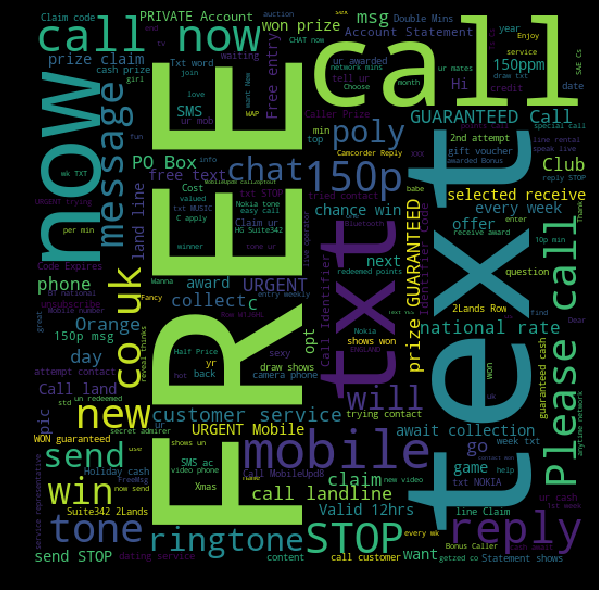

In [12]:
# Filter only messages that are spam, then select only the message
# feature and join all messages into a whitespace separated string
spam_words = ' '.join(list(mail[mail['label'] == 1]['message']))

spam_wc = WordCloud(width=512, height=512).generate(spam_words)
print('Spam Words')
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Ham Words


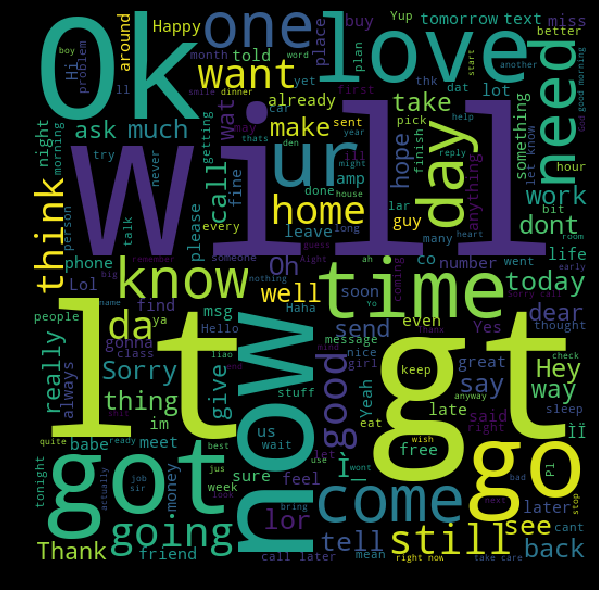

In [13]:
# Filter only messages that are ham, then select only the message
# feature and join all messages into a whitespace separated string
ham_words = ' '.join(list(mail[mail['label'] == 0]['message']))

ham_wc = WordCloud(width=512, height=512).generate(ham_words)
print('Ham Words')
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

WordCloud does some behind the scenes work to count word frequencies, and then present the results scaled in size based on the relative frequency of each word out of all spam or ham words.

We can get a quick glimpse of the stark differences in vocabulary between the two categories of mail. Spam has frequently occuring words suchas 'free', 'call', 'text', 'mobile', and 'now'. On the other hand, frequently occuring ham words have a much more conversational tone, with examples like 'will', 'ok', 'love', 'time', and some internet slang such as 'lt' and 'gt'. We so see some commonality in overlap in frequently used words, as 'now' appears pretty big in both clouds, but overall the vocublary sets are fairly distinct.

- We should at least keep **'now'** in mind as a word that should be left out of the classification decisons since it is heavily used in both vocabulary sets. 
-  It would be a good idea to look at the numbers behind the words more closely to make sure we're not missing any other eggregious examples.

In [14]:
spam_freq = FreqDist(spam_words.split(' '))
spam_freq = pd.DataFrame(sorted( ((v,k) for k,v in spam_freq.items()), reverse=True))

display('Spam Words Frequencies', spam_freq.head(10))
print('Total Spam Words: ', len(spam_freq))

'Spam Words Frequencies'

,0,1
0,604,to
1,358,a
2,187,your
3,185,or
4,185,call
5,178,the
6,169,for
7,169,2
8,164,you
9,143,is


Total Spam Words:  4313


In [15]:
ham_freq = FreqDist(ham_words.split(' '))
ham_freq = pd.DataFrame(sorted( ((v,k) for k,v in ham_freq.items()), reverse=True))

display('Ham Words Frequencies', ham_freq[40:50])
print('Total Ham Words: ', len(ham_freq))

'Ham Words Frequencies'

,0,1
40,209,we
41,209,like
42,202,know
43,200,got
44,197,come
45,191,was
46,191,call
47,191,all
48,189,just
49,188,or


Total Ham Words:  12480


One thing that is noticable when we move these word frequencies into a dataframe is that the Wordcloud visualization left out stopwords such as 'to', 'a', and 'you', 'the', and 'I'. When it comes to making our classifier, this is a practice we'll want to integrate, since these words don't carry a lot of entropy, and are likely to appear a lot in both spam and ham vocabulary sets.

In general, the ham messages appear to have a lot more of these filler words, and have about 3x more variation in vocabulary. Now, we'll use a helper function to call some other helper functions that will finish off preprocessing the text by getting rid of stopword, noise, short words, and then finally stemming each word.

In [27]:
%run ./TextCorpus.py
from TextCorpus import PreProcessText as pt
import TextCorpus as tc

spam = list(mail[mail['label'] == 1]['message'])
ham = list(mail[mail['label'] == 0]['message'])

In [28]:
ham_words = process_message(ham[0], 1)
display(ham_words)

['jurong',
 'point',
 'crazy..',
 'avail',
 'bugi',
 'great',
 'world',
 'buffet',
 '...',
 'cine',
 'got',
 'amor',
 'wat',
 '...']

In [29]:
spam_words = process_message(spam[0], 1)
display(spam_words)

['free',
 'entri',
 'wkli',
 'comp',
 'win',
 'cup',
 'final',
 'tkt',
 '21st',
 'may',
 '2005.',
 'text',
 '87121',
 'receiv',
 'entri',
 'question',
 'std',
 'txt',
 'rate',
 'appli',
 '08452810075over18']

### Training the Model

Next we'll need to create a class to support the classification model we're going to build. This model manual build of a Naive Bayes algorithm (though this could be done just as well with a package such as sklearn.

We can build a couple of options into our model, namely *Bag of Words* and *Term Frequency-Inverse Document Frequency (TD-IDF)* that will help our classifier make predictions on if future messages are spam or ham.


#### Bag of Words Equation:

<img src='https://cdn-images-1.medium.com/max/1600/1*wArU3CMFB9kqhQaZUYt-1w.png'>

#### TF-IDF Equation:

<img src='https://cdn-images-1.medium.com/max/1600/1*WHwfRvjRyHEH5kPOom9bOg.png'>

With TD-IDF, the more often a word occurs, the less entropy it is considered to have... i.e. if a word is in a dataset a lot, it gives less information tha words that occur less frequently. For this model, we will push forward with TD-IDF, where the probabilty of each word is counted as:

<img src='https://cdn-images-1.medium.com/max/1600/1*1fs2l79_ivrA2QbpLjzi2Q.png'>

In [18]:
class SpamClassifier(object):
    def __init__(self, train_data, method='tf-idf', gram=2):
        self.messages = train_data['message']
        self.label = train_data['label']
        self.method = method
        
    def calc_TF_IDF(self):
        numMessages = len(self.messages)
        self.spam_messages = self.label.value_counts()[1]
        self.ham_messages = self.label.value_counts()[0]
        self.total_messages = self.spam_messages + self.ham_messages
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = {}
        self.tf_ham = {}
        self.idf_spam = {}
        self.idf_ham = {}
        for i in range(numMessages):
            processed = process_message(self.messages[i], 1)
            count = []
            for word in processed:
                if self.label[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count: count += [word]

            for word in count:
                if self.label[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1
    
    def calc_TFIDF(self):
        self.prob_spam = {}
        self.prob_ham = {}
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = self.tf_spam[word] * \
            log((self.spam_messages + self.ham_messages) / \
                 self.idf_spam[word] + self.idf_ham.get(word, 0))
            self.sum_tf_idf_spam += self.prob_spam[word]
            
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) * \
            (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = self.tf_ham[word] * \
            log((self.spam_messages + self.ham_messages) / \
                 self.idf_ham[word] + self.idf_spam.get(word, 0))
            self.sum_tf_idf_ham += self.prob_ham[word]
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) * \
            (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
        self.prob_spam_message = self.spam_messages / self.total_messages
        self.prob_ham_message = self.ham_messages / self.total_messages
            
    def calc_prob(self):
        self.prob_spam = {}
        self.prob_ham = {}
        
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1)\
            / (self.spam_words + len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1)\
            / (self.ham_words + len(list(self.tf_ham.keys())))
            
        self.prob_spam_message = self.spam_messages / self.total_messages
        self.prob_ham_message = self.ham_messages / self.total_messages
        
    def train(self):
        self.calc_TF_IDF()
        if self.method == 'tf-idf': self.calc_TFIDF()
        else: self.calc_prob()
            
    def classify(self, message):
        p_spam, p_ham = 0, 0
        for word in message:
            if word in self.prob_spam:
                p_spam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    p_spam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    p_spam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            
            if word in self.prob_ham:
                p_ham += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    p_ham -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
                else:
                    p_ham -= log(self.ham_words + len(list(self.prob_ham.keys())))
            p_spam += log(self.prob_spam_message)
            p_ham += log(self.prob_ham_message)
        return p_spam >= p_ham
    
    def predict(self, test_data):
        result = {}
        for (i, message) in enumerate(test_data):
            message = process_message(message, 1)
            result[i] = int(self.classify(message))
        return result

To make the model more robust, and to ensure that it can handle words that's it's yet to encounter when new messages start getting introduced, we've introduced **additive smoothing** to ensure that any new word introduced has a probability that is a finite number (i.e. not zero).

According to Towards Data Science, "In additive smoothing we add a number alpha to the numerator and add alpha times number of classes over which the probability is found in the denominator." If alpha = 1, the smoothing is known as *Laplace*

### Classification

-  For the ```classify``` function, first each message is preprocessed. 
-  After that is complete, probability scores are called for each individual word to find the product of $P(w|spam)$. 
  -  If ```w``` isn't in the training dataset, ```TF(w)``` is called as 0, and then $P(w|spam)$ is calculated. 
  - This product is then multiplied by P(spam), where the resulting product is $P(spam|message)$
- These same rules apply when it comes to calculating ham probability scores

In [19]:
# Function to preprocess the text of each message to filter out stop words
# as well as conduct things like stemming to the desired format
def process_message(message, gram=1):
    message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    stop_words = sw.words('english')
    stop_words.extend(['call', 'now', 'will'])
    words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]   
    return words

In [20]:
def metrics(label, prediction):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(label)):
        tp += int(label[i] == 1 and prediction[i] == 1)
        tn += int(label[i] == 0 and prediction[i] == 0)
        fp += int(label[i] == 0 and prediction[i] == 1)
        fn += int(label[i] == 1 and prediction[i] == 0)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print('Precision: {}\nRecall: {}\nF-Score: {}\nAccuracy: {}'\
            .format(precision, recall, fscore, accuracy))

In [21]:
clf_tfidf = SpamClassifier(train_data, 'tf-idf', gram=1)
clf_tfidf.train()

preds_tfidf = clf_tfidf.predict(test_data['message'])
metrics(test_data['label'], preds_tfidf)

Precision: 0.9281045751633987
Recall: 0.7244897959183674
F-Score: 0.8137535816618912
Accuracy: 0.9520295202952029


In [22]:
clf_bow = SpamClassifier(train_data, 'bow', 1)
clf_bow.train()
preds_bow = clf_bow.predict(test_data['message'])
metrics(test_data['label'], preds_bow)

Precision: 0.9052631578947369
Recall: 0.4387755102040816
F-Score: 0.5910652920962199
Accuracy: 0.9121771217712177


In [23]:
pm = process_message('I cant pick the phone right now. Pls send a message')
clf_bow.classify(pm)

False

In [24]:
pm = process_message('Congratulations ur awarded $500 ')
clf_bow.classify(pm)

True

In [25]:
pm = process_message('You win!! Click here')
clf_bow.classify(pm)

False

## Prebuilt Classifiers

It's great to understand the nuts and bolts behind how classifiers work, especially for something like spam. However, in most cases you will likely find yourself using prebuilt packages to do most of the heavy lifting instead of reinventing the wheel. Scikit-Learn is an excellent resource for building many types of classifiers.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import nltk.stem

stemmer = nltk.stem.SnowballStemmer('english')

class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))


In [30]:
vectors = StemmedTfidfVectorizer(stop_words='english', 
                                 decode_error='ignore')
train_tokens = vectors.fit_transform(train_data['message'])
num_samples, num_features = train_tokens.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 4217, #features: 6162


In [31]:
#test_tokens = vectors.fit_transform(test_data['message'])
test_tokens = vectors.transform(test_data['message'])
num_samples, num_features = test_tokens.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 1355, #features: 6162


In [32]:
features = train_data
feature_names = vectors.get_feature_names()
target = np.array(features['label'])
target_names = np.array(['ham', 'spam'])
labels = target_names[target]
is_spam = (labels == 'spam')
message = np.array(features['message'])

In [33]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
        n_estimators=600,
        learning_rate=1.25,
        algorithm="SAMME")
clf.fit(train_tokens, labels)

preds = clf.predict(test_tokens)

In [34]:
results = pd.DataFrame()
results['actual'] = test_data['label'].map({1: 'spam', 0: 'ham'})
results['prediction'] = preds
results['message'] = test_data['message']
display(results[175:200])

,actual,prediction,message
175,ham,ham,Mum ask Ì_ to buy food home...
176,ham,ham,"Sorry, I'll call later"
177,ham,ham,What is important is that you prevent dehydrat...
178,ham,ham,Height of Confidence: All the Aeronautics prof...
179,spam,spam,+449071512431 URGENT! This is the 2nd attempt ...
180,spam,spam,You have WON a guaranteed å£1000 cash or a å£2...
181,ham,ham,Ya even those cookies have jelly on them
182,ham,ham,Of cos can lar i'm not so ba dao ok... 1 pm lo...
183,ham,ham,"Alright omw, gotta change my order to a half8th"
184,ham,ham,Dunno y u ask me.


In [35]:
pred_spam = len(results[results['prediction'] == 'spam'])
tp = len(results[results['actual'] == 'spam'])
fp = tp - pred_spam

In [36]:
pred_ham = len(results[results['prediction'] == 'ham'])
tn = len(results[results['actual'] == 'ham'])
fn = pred_ham - tn

In [37]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)
fscore = (2 * tp) / (2 * (tp + fp + fn))

In [38]:
print('Precision: ', precision)
print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('F-Score: ', fscore)

Precision:  0.9032258064516129
Accuracy:  0.9699355762347889
Recall:  0.9032258064516129
F-Score:  0.8235294117647058
